In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

%matplotlib inline

In [2]:
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
sys.path.append("/home/Developer/NCSN-TF2.0/")

import PIL
import utils, configs
import argparse
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import matplotlib.pyplot as plt

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from tensorflow.keras import Model, layers
from tensorflow.keras.layers import Input, Flatten, Dense, AvgPool2D

from datasets.dataset_loader import  *
from tqdm import tqdm
from sklearn.metrics import classification_report, average_precision_score
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

from PIL import Image
from IPython.display import display
from matplotlib.pyplot import imshow
from datetime import datetime

import seaborn as sns
import matplotlib as mpl
sns.set(style="darkgrid")
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16

seed=42
tf.random.set_seed(seed)
np.random.seed(seed)

tf.__version__

'2.2.0'

In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.config.experimental.list_physical_devices('GPU')

Num GPUs Available:  1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [5]:
def get_command_line_args(_args):
    parser = utils._build_parser()

    parser = parser.parse_args(_args)

    utils.check_args_validity(parser)

    print("=" * 20 + "\nParameters: \n")
    for key in parser.__dict__:
        print(key + ': ' + str(parser.__dict__[key]))
    print("=" * 20 + "\n")
    return parser

In [6]:
def metrics(inlier_score, outlier_score, plot=False, verbose=False):
    from sklearn.metrics import roc_curve
    from sklearn.metrics import classification_report, average_precision_score
    from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
    
    y_true = np.concatenate((np.zeros(len(inlier_score)),
                             np.ones(len(outlier_score))))
    y_scores = np.concatenate((inlier_score, outlier_score))
    
    prec,rec,thresh = precision_recall_curve(y_true, y_scores)
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    
    roc_auc = roc_auc_score(y_true,y_scores)
    pr_auc = auc(rec,prec)
    ap = average_precision_score(y_true,y_scores)
    
    if plot:    
    
        fig, axs = plt.subplots(1,2, figsize=(16,4))

        sns.lineplot(fpr, tpr, ax=axs[0])
        axs[0].set(
            xlabel="FPR", ylabel="TPR", title="ROC"
        )

        sns.lineplot(rec, prec, ax=axs[1])
        axs[1].set(
            xlabel="Recall", ylabel="Precision", title="Precision-Recall"
        )

        plt.show()
        plt.close()
    
    if verbose:
        print("Inlier vs Outlier")
        print("----------------")
        print("ROC-AUC: {:.4f}".format(roc_auc))
        print("PR-AUC: {:.4f}".format(pr_auc))
        print("Avg Prec: {:.4f}".format(ap))
        
    return roc_auc, ap, pr_auc

In [7]:
from scipy.ndimage import uniform_filter, median_filter

#Smooth first to get rid of spurious outliers
def preproc(x, orig=None):
    x = np.abs(uniform_filter(x, size=3))
    
    # Only consider foreground pixels
#     x = x[orig>0]
    return x

# Selecting Quantile for best separation
def getQuantiles(logits,orig, Q=0.95):    
    quants = [np.quantile(preproc(x,o), Q) for x,o in zip(logits, orig)]
    quants = np.array(quants).reshape(-1,1)
    return quants

## Generating Samples

In [8]:
args = get_command_line_args(["--model=refinenet",
                              "--checkpoint_dir=saved_models/",
                              "--filters=64",
                              "--dataset=seg_brain",
                              "--sigma_low=0.01",
                              "--sigma_high=1",
                              "--y_cond"
                             ])
configs.config_values = args
NUM_L = configs.config_values.num_L
SIGMA_HIGH = configs.config_values.sigma_high
SIGMA_LOW = configs.config_values.sigma_low
BEST_SIGMA_IDX = configs.config_values.num_L - 1
SIGMA_LEVELS = tf.math.exp(tf.linspace(tf.math.log(SIGMA_HIGH),
                                       tf.math.log(SIGMA_LOW),
                                       NUM_L))
SPLITS = utils.dict_splits[configs.config_values.dataset]
SPLITS

Parameters: 

experiment: train
dataset: seg_brain
model: refinenet
filters: 64
num_L: 10
sigma_low: 0.01
sigma_high: 1.0
sigma_sequence: geometric
steps: 200000
learning_rate: 0.001
batch_size: 128
samples_dir: ./samples/
checkpoint_dir: saved_models/
checkpoint_freq: 5000
resume: True
resume_from: -1
init_samples: 
k: 10
eval_setting: sample
ocnn: False
y_cond: True
max_to_keep: 2



(1, 7)

In [9]:
# save_dir, complete_model_name = utils.get_savemodel_dir()
# brain_model_cond, _, step, _,_ = utils.try_load_model(save_dir,
#                                               step_ckpt=configs.config_values.resume_from,
#                                               verbose=True)

In [10]:
args = get_command_line_args(["--model=refinenet",
                              "--checkpoint_dir=saved_models/",
                              "--filters=64",
                              "--dataset=brain",
                              "--sigma_low=0.01",
                              "--sigma_high=1",
                             ])
configs.config_values = args
save_dir, complete_model_name = utils.get_savemodel_dir()
brain_model, _, step, _,_ = utils.try_load_model(save_dir,
                                              step_ckpt=configs.config_values.resume_from,
                                              verbose=True)

Parameters: 

experiment: train
dataset: brain
model: refinenet
filters: 64
num_L: 10
sigma_low: 0.01
sigma_high: 1.0
sigma_sequence: geometric
steps: 200000
learning_rate: 0.001
batch_size: 128
samples_dir: ./samples/
checkpoint_dir: saved_models/
checkpoint_freq: 5000
resume: True
resume_from: -1
init_samples: 
k: 10
eval_setting: sample
ocnn: False
y_cond: False
max_to_keep: 2

(1, 91, 109, 1)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
images (InputLayer)             [(None, 91, 109, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 91, 109, 64)  640         images[0][0]                     
__________________________________________________________________________________________

In [11]:
SPLITS

(1, 7)

In [12]:
def load_outlier_data(age="1year"):
    
    DATA_DIR = "/home/Developer/anodetect/data/test/"
    test_paths = glob.glob(DATA_DIR+"/"+age+"/*")
    
    # Create a dictionary describing the features.
    image_feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'mask': tf.io.FixedLenFeature([], tf.string),
        'segmentation': tf.io.FixedLenFeature([], tf.string),
    }

    @tf.function
    def _parse_record(example_proto):
        # Parse the input tf.Example proto using the dictionary above.
        return tf.io.parse_single_example(example_proto, image_feature_description)

    @tf.function
    def _parse_mri(example_proto):
        
        # Get the record and put it into a feature dict
        image_features = _parse_record(example_proto)
        
        # Deserialize the mri array 
        mri = tf.io.parse_tensor(image_features['image'],
                                out_type=tf.float32)
        mask = tf.io.parse_tensor(image_features['mask'],
                                out_type=tf.float32)
        seg = tf.io.parse_tensor(image_features['segmentation'],
                                out_type=tf.float32)
        
        mri  = tf.expand_dims(mri, axis=-1)
        seg = tf.cast(tf.squeeze(seg), dtype=tf.int32)
        seg = tf.one_hot(seg, depth=7)
#         x = tf.concat((mri,mask,seg), axis=-1)
        x = tf.concat((mri,seg), axis=-1)
        
        return x

    test  = tf.data.TFRecordDataset(test_paths).map(_parse_mri)

    return test, len(test_paths)

In [13]:
# import tensorflow.keras as keras

# def build(model):
#     x = [layers.Input(name="images", shape=model.in_shape[0][1:]),
#                  layers.Input(name="idx_sigmas", shape=(), dtype=tf.int32)]
#     return keras.Model(inputs=x, outputs=model.call(x))

# m= build(brain_model)
# m.summary()

In [14]:
brain_model

In [15]:
SIGMAS = utils.get_sigma_levels().numpy()

> ### Note that since we do not have masks, background values are not exactly zero
> ### Use an eps instead (default: 1e-10)

In [16]:
@tf.function
def perturb(x):
    x_batch, y_cond = tf.split(x, SPLITS, axis=-1)
    perturbation =  tf.random.normal(shape=x_batch.shape, mean=0, stddev=SIGMA_VALUE)
    x_perturbed = x_batch + perturbation
    x = tf.concat((x_perturbed, y_cond), axis=-1)
    return x

@tf.function
def score_batch(x_batch):
#     x_batch = perturb(x_batch)
    score = brain_model([x_batch, idx_sigmas])
    return score

In [17]:
@tf.function
def remove_segs(x):
    x, segs = tf.split(x, SPLITS, axis=-1)
    return x

In [22]:
%%time
# TEST_BATCH=min_size//10
# BATCH_COUNT = test_size // TEST_BATCH
# print("Testing {} batches of {}: {} samples".format(BATCH_COUNT, TEST_BATCH, TEST_BATCH*BATCH_COUNT))

ages = ["1year", "2year", "4year", "6year", "8year"]
outlier_datasets = []
for age in ages:
    x_outlier, test_size = load_outlier_data(age)
    print(age, test_size)
    batch_count = 10
    batch_size = test_size // batch_count
    
    x_outlier = x_outlier.shuffle(1000)
    x_outlier = x_outlier.map(remove_segs)
    x_outlier = x_outlier.batch(batch_size).take(batch_count).prefetch(tf.data.experimental.AUTOTUNE).cache()
    outlier_datasets.append(x_outlier)

1year 756
2year 582
4year 519
6year 570
8year 318
CPU times: user 234 ms, sys: 47.4 ms, total: 281 ms
Wall time: 272 ms


### Getting train/test inlier distributions

In [23]:
!ls /home/Developer/anodetect/data/processed/images/test | wc -l

1137


In [24]:
x_train_, x_test_ =  get_train_test_data("seg_brain")
x_test_ = x_test_.map(remove_segs).batch(200)

x_train = x_train_.map(remove_segs).batch(256).prefetch(tf.data.experimental.AUTOTUNE)

inlier_batches = [x for x in x_test_]
len(inlier_batches), [x.shape[0] for x in inlier_batches]

(6, [200, 200, 200, 200, 200, 137])

## Mixing Scores

In [25]:
def compute_scores(x_test):
    
    # Sigma Idx -> Score
    score_dict = []
    
    sigmas = utils.get_sigma_levels().numpy()
    final_logits = 0 #tf.zeros(logits_shape)
    progress_bar = tqdm(SIGMAS, desc='Sigma: ?')
    for idx, sigma in enumerate(progress_bar):
        
        progress_bar.set_description("Sigma: {:.4f}".format(sigma))
        _logits =[]

        for x_batch in x_test:
            idx_sigmas = tf.ones(x_batch.shape[0], dtype=tf.int32) * idx
            score = brain_model([x_batch, idx_sigmas])
#             x_batch, y_cond = tf.split(x_batch, SPLITS, axis=-1)
#             score = tf.where(x_batch > 1e-10, score,  0)
            _logits.append(score)

        _logits = tf.concat(_logits, axis=0)
        score_dict.append(tf.identity(_logits))
        
#         final_logits += _logits * sigma
    
    return score_dict

In [35]:
%%time
train_dist = compute_scores(x_train)

Sigma: 0.0100: 100%|██████████| 10/10 [14:20<00:00, 86.08s/it]

CPU times: user 5min 49s, sys: 7min 32s, total: 13min 22s
Wall time: 14min 20s


In [26]:
%%time
inlier_dist = compute_scores(inlier_batches)

Sigma: 0.0100: 100%|██████████| 10/10 [01:36<00:00,  9.62s/it]

CPU times: user 29.4 s, sys: 27.3 s, total: 56.7 s
Wall time: 1min 36s


In [27]:
%%time
outlier_dists = []
for outlier in outlier_datasets:
    outlier_dists.append(compute_scores(outlier))

Sigma: 0.0100: 100%|██████████| 10/10 [00:31<00:00,  3.13s/it]

CPU times: user 2min 8s, sys: 27.3 s, total: 2min 36s
Wall time: 4min 3s


### Original Separation

In [28]:
# L2-norm same as Frobenius
# train_score = tf.norm(train_dist[-1], axis=[1,2], ord="euclidean").numpy()
inlier_score =  tf.norm(inlier_dist[-1], axis=[1,2], ord="euclidean").numpy()
outlier_scores = []

for _dists in outlier_dists:
    outlier_scores.append(tf.norm(_dists[-1], axis=[1,2], ord="euclidean").numpy())
    
# outlier_scores = np.stack(outlier_scores)

In [140]:
[x[:len(inlier_score)].shape for x in outlier_scores]

[(337, 1), (337, 1), (337, 1), (337, 1)]

In [32]:
LABELS = ["Train", "ABCD"] + ages

df = pd.DataFrame(np.concatenate((
#                                   train_score[:len(inlier_score)],
                                  inlier_score[:300], 
                                  *[x[:300] for x in outlier_scores]), axis=-1),
             columns=LABELS[1:])
df.describe()

ABCD        1year        2year        4year        6year  \
count   300.000000   300.000000   300.000000   300.000000   300.000000   
mean   2982.610352  2749.226562  2742.549561  2855.853027  2912.384766   
std     165.497910   255.351822   234.079193   245.829834   217.622498   
min    2476.692871  2196.971436  2242.428711  2244.531738  2188.776123   
25%    2888.098938  2547.403931  2560.876648  2674.433472  2782.233643   
50%    2986.528198  2744.308838  2729.155640  2863.190674  2916.432129   
75%    3078.693054  2923.779602  2911.649597  3049.291504  3066.056091   
max    3496.048340  3461.829346  3375.641602  3408.422119  3385.172852   

             8year  
count   300.000000  
mean   2960.012451  
std     197.146790  
min    2378.042480  
25%    2842.515930  
50%    2973.324097  
75%    3096.338013  
max    3410.557617

In [81]:
mpl.rcParams['figure.dpi'] = 200
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 18

In [36]:
LABELS

['Train', 'ABCD', '1year', '2year', '4year', '6year', '8year']

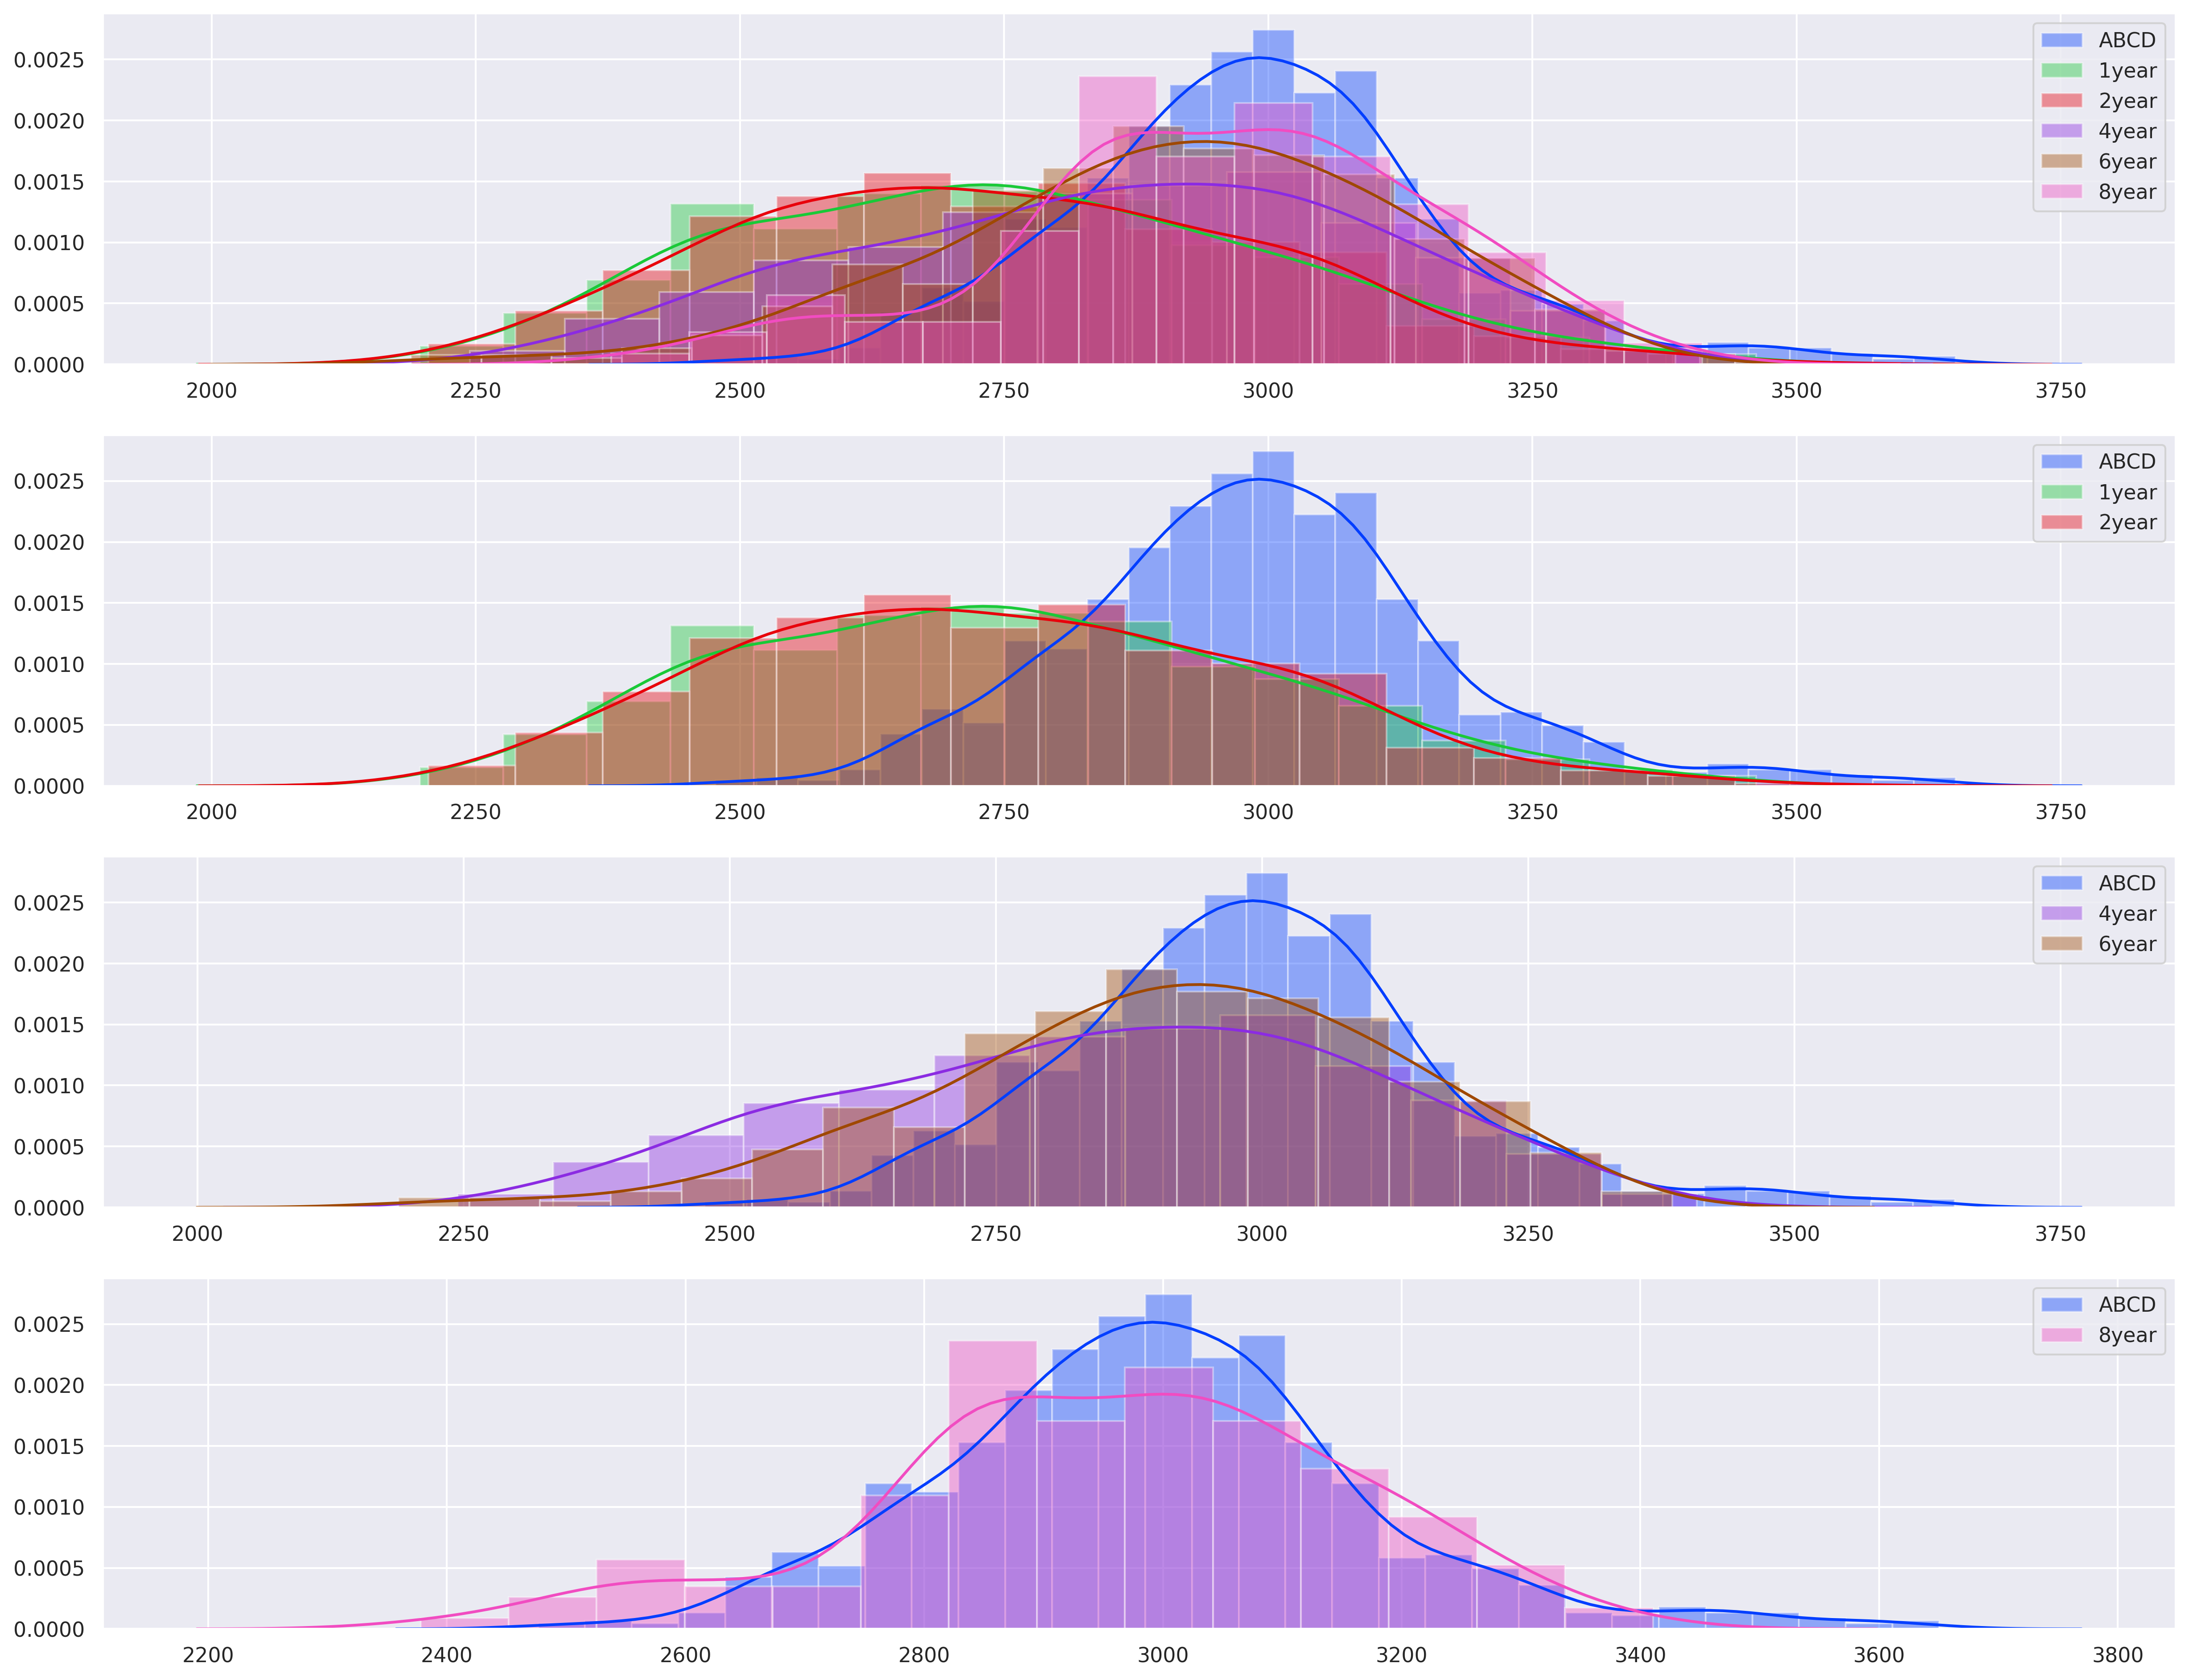

In [37]:
COLORS = sns.color_palette("bright")
# COLORS[0] = "blue" 
# COLORS[1] = "red" 

fig, axs = plt.subplots(4,1, figsize=(20,16))

# sns.distplot(train_score, color=COLORS[0], label=LABELS[0], ax=axs[0])
sns.distplot(inlier_score, color=COLORS[0], label=LABELS[1], ax=axs[0])
for idx, _score in enumerate(outlier_scores):
    idx += 2
    sns.distplot(_score, color=COLORS[idx], label=LABELS[idx], ax=axs[0])

start = 0
for col in range(1, axs.shape[0]):
    sns.distplot(inlier_score, color=COLORS[0], label=LABELS[1], ax=axs[col])
    
    for idx, _score in enumerate(outlier_scores[start:start+2]):
        idx += 2*col
        sns.distplot(_score, color=COLORS[idx], label=LABELS[idx], ax=axs[col])    
    
    start += 2
for ax in axs: ax.legend()
plt.show()

### Mixing Scores

In [40]:
# L2-norm same as Frobenius
# train_agg = tf.add_n([inlier_train_dist[x] * s for x, s in enumerate(SIGMAS)])
# train_score = tf.norm(train_agg, axis=[1,2], ord="euclidean").numpy()

inlier_agg = tf.add_n([inlier_dist[x] * s for x, s in enumerate(SIGMAS)])
inlier_score = tf.norm(inlier_agg, axis=[1,2], ord="euclidean").numpy()

outlier_scores = []
for _dists in outlier_dists:
    weighted_sum = tf.add_n([_dists[x] * s for x,s in enumerate(SIGMAS)])
    outlier_scores.append(tf.norm(weighted_sum, axis=[1,2], ord="euclidean").numpy())
    
# outlier_scores = np.stack(outlier_scores)

In [41]:
[x[:len(inlier_score)].shape for x in outlier_scores]

[(750, 1), (580, 1), (510, 1), (570, 1), (310, 1)]

In [43]:
LABELS = ["Train", "ABCD"] + ages

df = pd.DataFrame(np.concatenate((
#                     train_score[:len(inlier_score)],
                    inlier_score[:300], 
                    *[x[:300] for x in outlier_scores]), axis=-1),
                 columns=LABELS[1:])
df.describe()

ABCD       1year       2year       4year       6year       8year
count  300.000000  300.000000  300.000000  300.000000  300.000000  300.000000
mean   353.842255  370.953461  366.023773  366.093536  359.979950  370.360107
std     12.871537   14.999925   12.823471   24.316772   25.639778   12.730024
min    328.867126  326.213196  329.825012  318.412415  312.107697  341.757751
25%    344.212730  359.156311  357.740463  346.329033  340.195572  362.387306
50%    353.371460  371.871185  366.578156  361.199692  353.869781  369.018036
75%    361.817039  381.525528  375.402748  383.586418  376.790436  378.455086
max    404.612152  404.993317  402.107910  434.872192  434.966034  409.894318

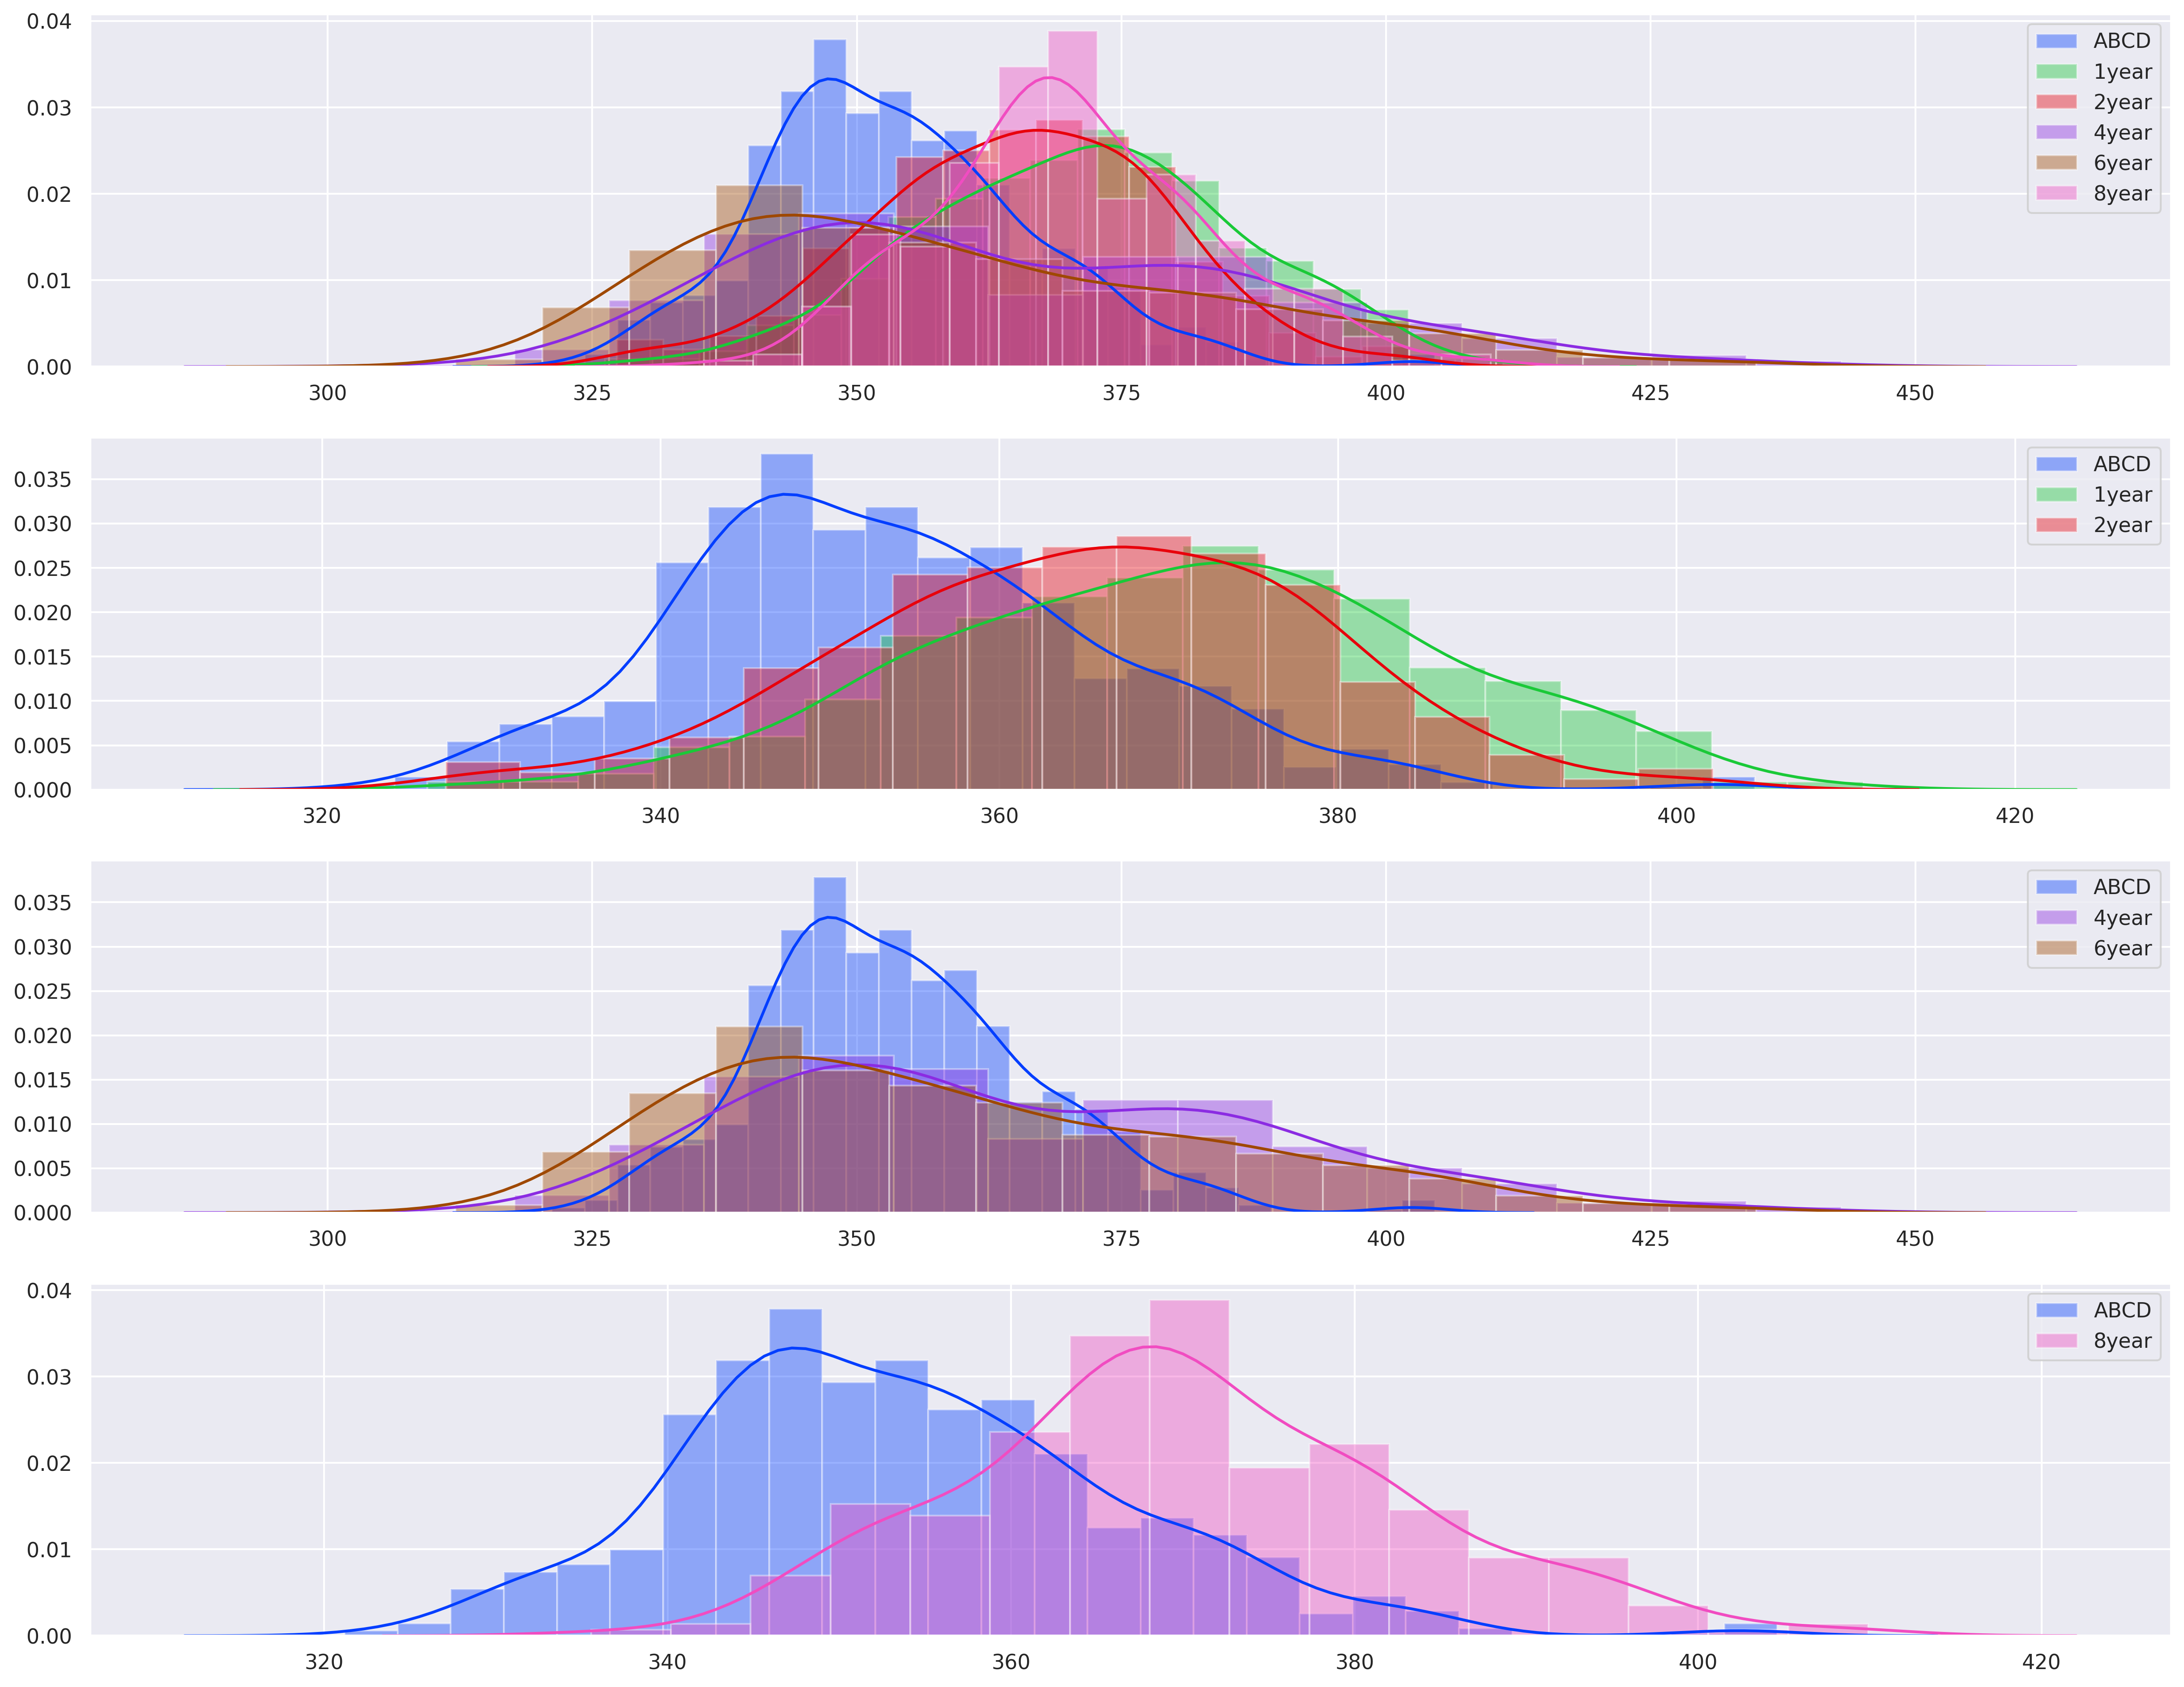

In [44]:
COLORS = sns.color_palette("bright")
# COLORS[0] = "blue" 
# COLORS[1] = "red" 

fig, axs = plt.subplots(4,1, figsize=(20,16))

# sns.distplot(train_score, color=COLORS[0], label=LABELS[0], ax=axs[0])
sns.distplot(inlier_score, color=COLORS[0], label=LABELS[1], ax=axs[0])
for idx, _score in enumerate(outlier_scores):
    idx += 2
    sns.distplot(_score, color=COLORS[idx], label=LABELS[idx], ax=axs[0])

start = 0
for col in range(1, axs.shape[0]):
    sns.distplot(inlier_score, color=COLORS[0], label=LABELS[1], ax=axs[col])
    
    for idx, _score in enumerate(outlier_scores[start:start+2]):
        idx += 2*col
        sns.distplot(_score, color=COLORS[idx], label=LABELS[idx], ax=axs[col])    
    
    start += 2

for ax in axs: ax.legend(fontsize=16)
axs[-1].set(xlabel="Score Norms")
plt.show()

**ABCD vs 1-year**

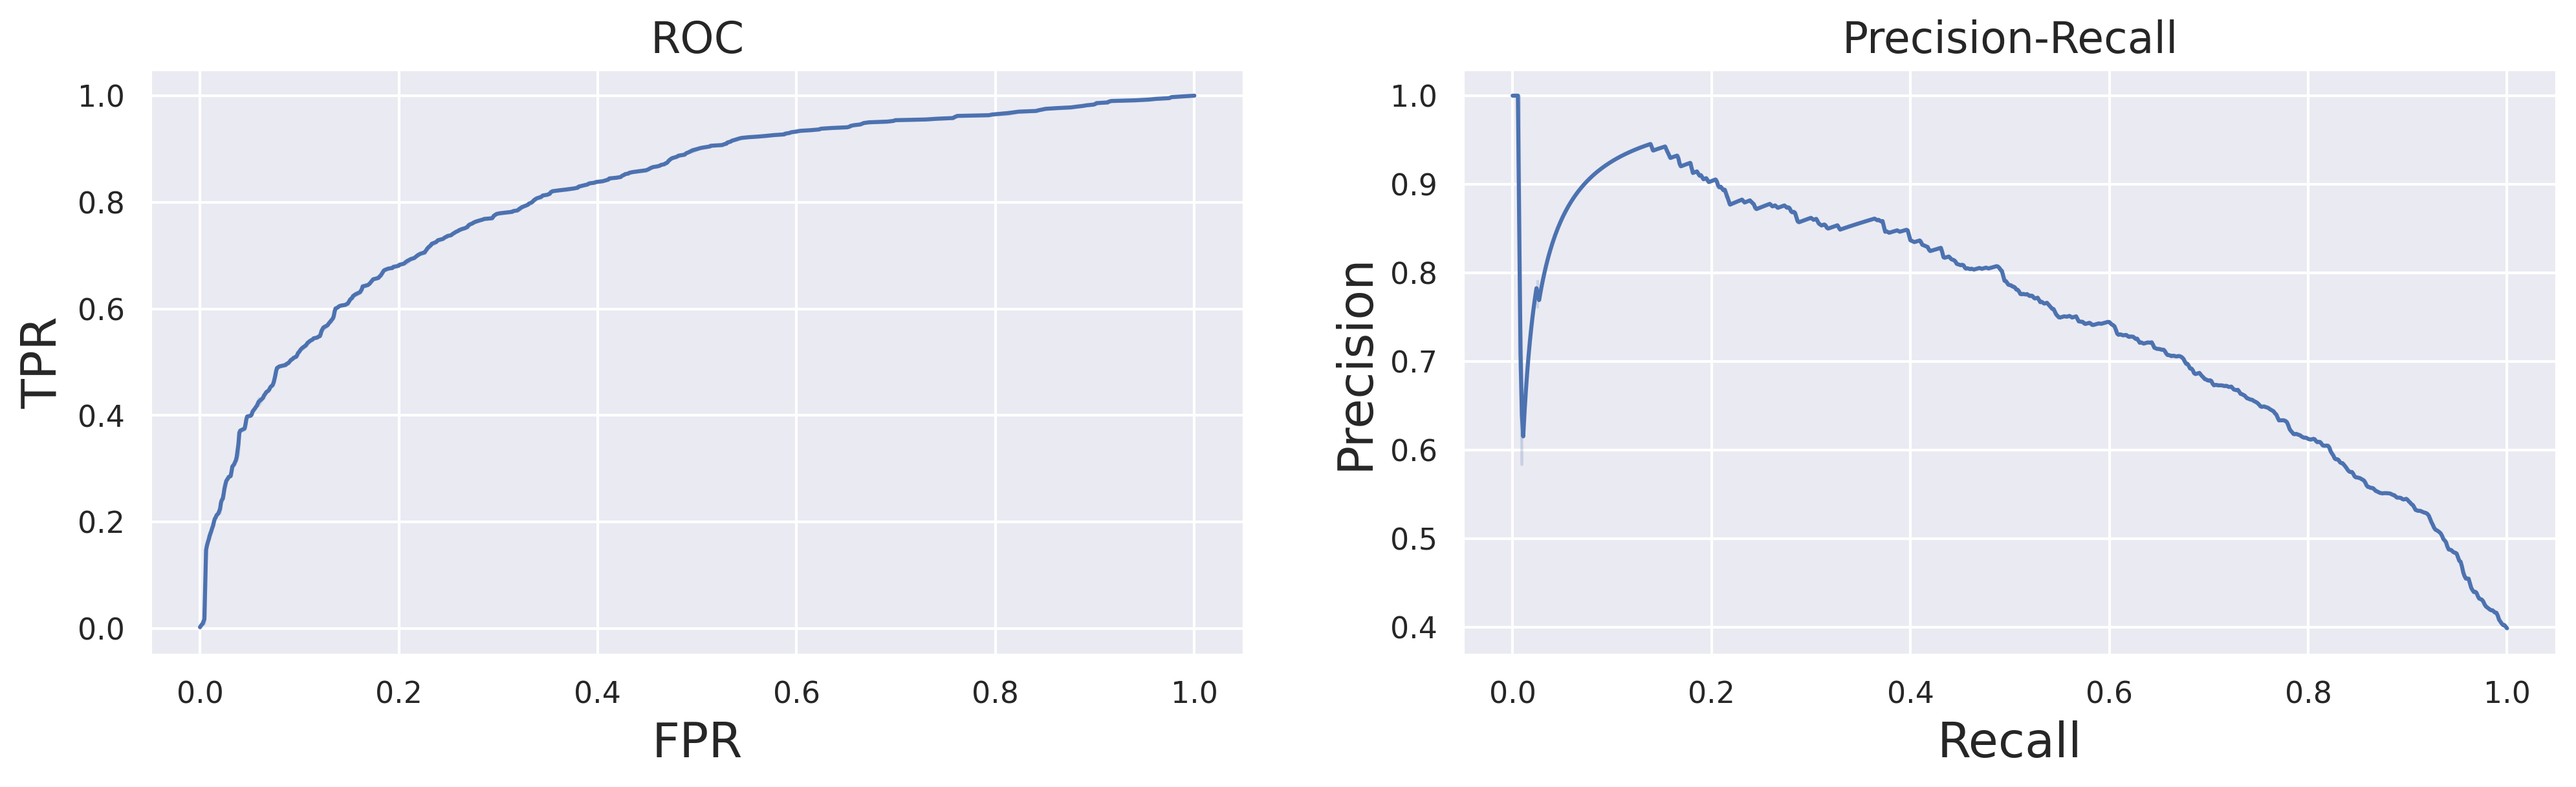

Inlier vs Outlier
----------------
ROC-AUC: 0.8164
PR-AUC: 0.7493
Avg Prec: 0.7498


In [45]:
metrics(inlier_score, outlier_scores[0], plot=True, verbose=True)
plt.show()

**ABCD vs 8-year**

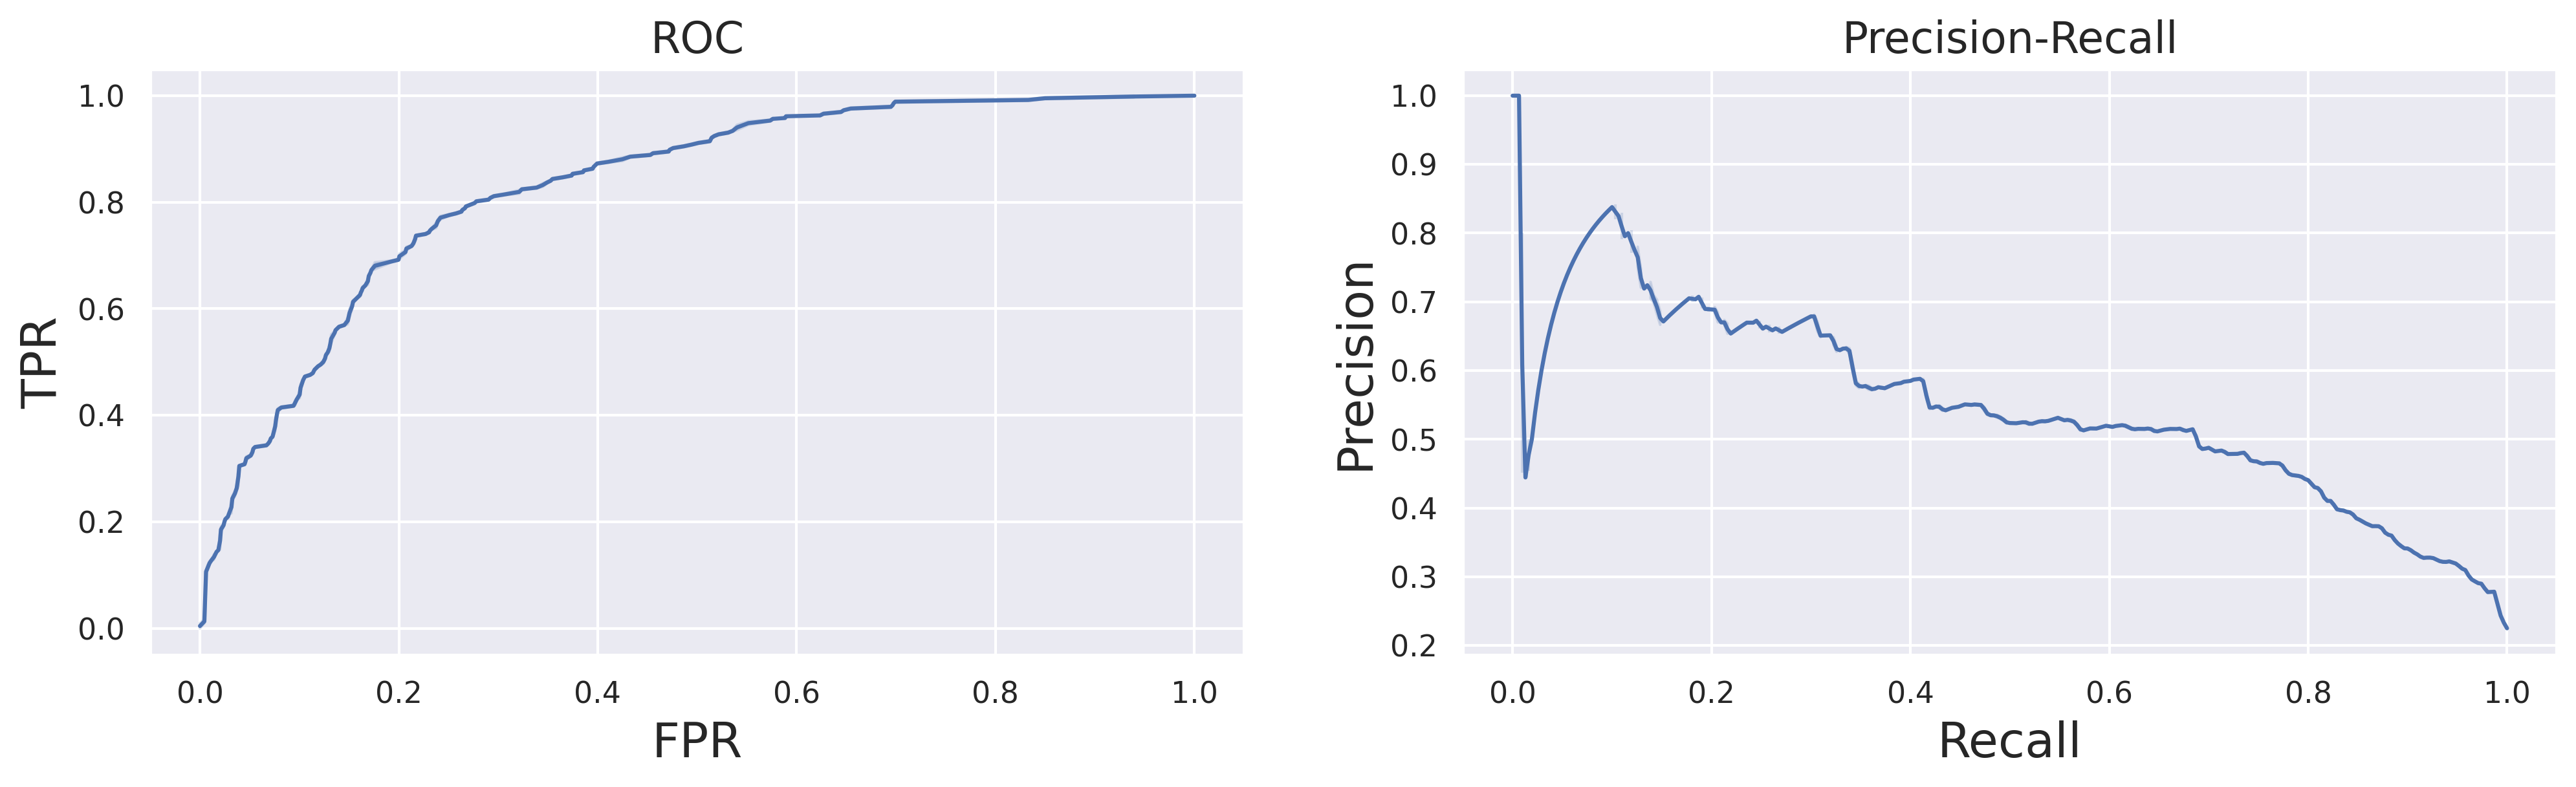

Inlier vs Outlier
----------------
ROC-AUC: 0.8266
PR-AUC: 0.5472
Avg Prec: 0.5488


In [46]:
metrics(inlier_score, outlier_scores[-1], plot=True, verbose=True)
plt.show()

In [73]:
# TODO: Plot all PR curves on one plot

In [ ]:
def metrics_multiplot(inlier_score, outlier_scores, plot=False, verbose=False):
    import numpy as np
    import seaborn as sns
    from sklearn.metrics import roc_curve
    from sklearn.metrics import classification_report, average_precision_score
    from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
    
    fig, axs = plt.subplots(1,2, figsize=(16,4))
    
    y_true = np.concatenate((np.zeros(len(inlier_score)),
                             np.ones(len(outlier_score))))
    y_scores = np.concatenate((inlier_score, outlier_score))
    
    prec,rec,thresh = precision_recall_curve(y_true, y_scores)
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    
    roc_auc = roc_auc_score(y_true,y_scores)
    pr_auc = auc(rec,prec)
    ap = average_precision_score(y_true,y_scores)
    
    if plot:    
    
        fig, axs = plt.subplots(1,2, figsize=(16,4))

        sns.lineplot(fpr, tpr, ax=axs[0])
        axs[0].set(
            xlabel="FPR", ylabel="TPR", title="ROC"
        )

        sns.lineplot(rec, prec, ax=axs[1])
        axs[1].set(
            xlabel="Recall", ylabel="Precision", title="Precision-Recall"
        )

        plt.show()
        plt.close()
    
    if verbose:
        print("Inlier vs Outlier")
        print("----------------")
        print("ROC-AUC: {:.4f}".format(roc_auc))
        print("PR-AUC: {:.4f}".format(pr_auc))
        print("Avg Prec: {:.4f}".format(ap))
        
    return roc_auc, ap, pr_auc

## Train Data = L2-norm(Pixel Scores)
> They are calculated separately since each patient has 3 samples 

In [47]:
%%time
inlier_train_dist = compute_scores(inlier_batches[:-1])
inlier_test_dist = compute_scores(inlier_batches[-1:])

Sigma: 0.0100: 100%|██████████| 10/10 [00:10<00:00,  1.06s/it]

CPU times: user 28.3 s, sys: 17.1 s, total: 45.4 s
Wall time: 1min 32s


In [52]:
%%time
train_data, test_data = [], []
outlier_norms = []

for x, s in enumerate(SIGMAS):
    train_data.append(tf.norm(inlier_train_dist[x] * s, axis=[1,2], ord="euclidean").numpy())
    test_data.append(tf.norm(inlier_test_dist[x] * s, axis=[1,2], ord="euclidean").numpy())
train_data = np.concatenate(train_data, axis=1)
test_data = np.concatenate(test_data, axis=1)

for _dists in outlier_dists:
    norms = [tf.norm(_dists[x] * s, axis=[1,2]).numpy() for x, s in enumerate(SIGMAS)]
    outlier_norms.append( np.concatenate(norms, axis=1))

CPU times: user 54.7 ms, sys: 45.2 ms, total: 99.9 ms
Wall time: 79.3 ms


In [53]:
train_data.shape,test_data.shape, [x.shape for x in outlier_norms]

((1000, 10),
 (137, 10),
 [(750, 10), (580, 10), (510, 10), (570, 10), (310, 10)])

In [54]:
X_train, X_test = train_data, test_data

### OC-SVM

In [55]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from helper import plot_confusion_matrix

In [56]:
%%time
clf = svm.OneClassSVM(nu=0.01, kernel="rbf")
clf.fit(train_data)

CPU times: user 3.49 ms, sys: 1.84 ms, total: 5.33 ms
Wall time: 3.79 ms


OneClassSVM(nu=0.01)

In [60]:
y_true = np.concatenate((np.zeros(len(test_data)),
                         np.ones(len(outlier_norms[0]))))

# Rescaling: 0 = inlier , 1 = outlier
test_pred = (1-clf.predict(test_data)) // (2)
outlier_pred = (1-clf.predict(outlier_norms[0])) // 2
y_pred = np.concatenate((test_pred, outlier_pred))

print(classification_report(y_true, y_pred, target_names=["Inlier","1-Year"]))

              precision    recall  f1-score   support

      Inlier       0.41      1.00      0.58       137
      1-Year       1.00      0.74      0.85       750

    accuracy                           0.78       887
   macro avg       0.71      0.87      0.72       887
weighted avg       0.91      0.78      0.81       887



> **Low precision => Low PPV => High False Positives**

### Grid Search
> **Defaults w/ rbf seem to work best**

In [61]:
y_train = np.ones(len(train_data))

params = {"nu":[0.01, 0.02, 0.001],
          "gamma": ["scale", "auto"],
          "shrinking": [True, False],
          "kernel": ["rbf", "poly", "sigmoid"]
         }

grid = GridSearchCV(estimator=svm.OneClassSVM(), param_grid=params, n_jobs=12,
                    cv=10, scoring="precision", verbose=1)
print(grid)

GridSearchCV(cv=10, estimator=OneClassSVM(), n_jobs=12,
             param_grid={'gamma': ['scale', 'auto'],
                         'kernel': ['rbf', 'poly', 'sigmoid'],
                         'nu': [0.01, 0.02, 0.001],
                         'shrinking': [True, False]},
             scoring='precision', verbose=1)


In [62]:
%%time
grid.fit(train_data, y_train)

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    1.6s


CPU times: user 738 ms, sys: 1.25 s, total: 1.99 s
Wall time: 2.27 s


[Parallel(n_jobs=12)]: Done 360 out of 360 | elapsed:    2.1s finished


GridSearchCV(cv=10, estimator=OneClassSVM(), n_jobs=12,
             param_grid={'gamma': ['scale', 'auto'],
                         'kernel': ['rbf', 'poly', 'sigmoid'],
                         'nu': [0.01, 0.02, 0.001],
                         'shrinking': [True, False]},
             scoring='precision', verbose=1)

In [63]:
grid.best_params_

{'gamma': 'scale', 'kernel': 'rbf', 'nu': 0.01, 'shrinking': True}

In [64]:
%%time

clf = svm.OneClassSVM(**grid.best_params_)
clf.fit(train_data)

y_true = np.concatenate((np.zeros(len(test_data)),
                         np.ones(len(outlier_norms[0]))))

# Rescaling: 0 = inlier , 1 = outlier
test_pred = (1-clf.predict(test_data)) // (2)
outlier_pred = (1-clf.predict(outlier_norms[0])) // 2
y_pred = np.concatenate((test_pred, outlier_pred))

print(classification_report(y_true, y_pred, target_names=["Inlier","1-Year"]))

              precision    recall  f1-score   support

      Inlier       0.41      1.00      0.58       137
      1-Year       1.00      0.74      0.85       750

    accuracy                           0.78       887
   macro avg       0.71      0.87      0.72       887
weighted avg       0.91      0.78      0.81       887

CPU times: user 11.1 ms, sys: 3.74 ms, total: 14.8 ms
Wall time: 12.5 ms


Confusion matrix, without normalization
[[1.   0.  ]
 [0.26 0.74]]
Overall Accuracy: 0.7802


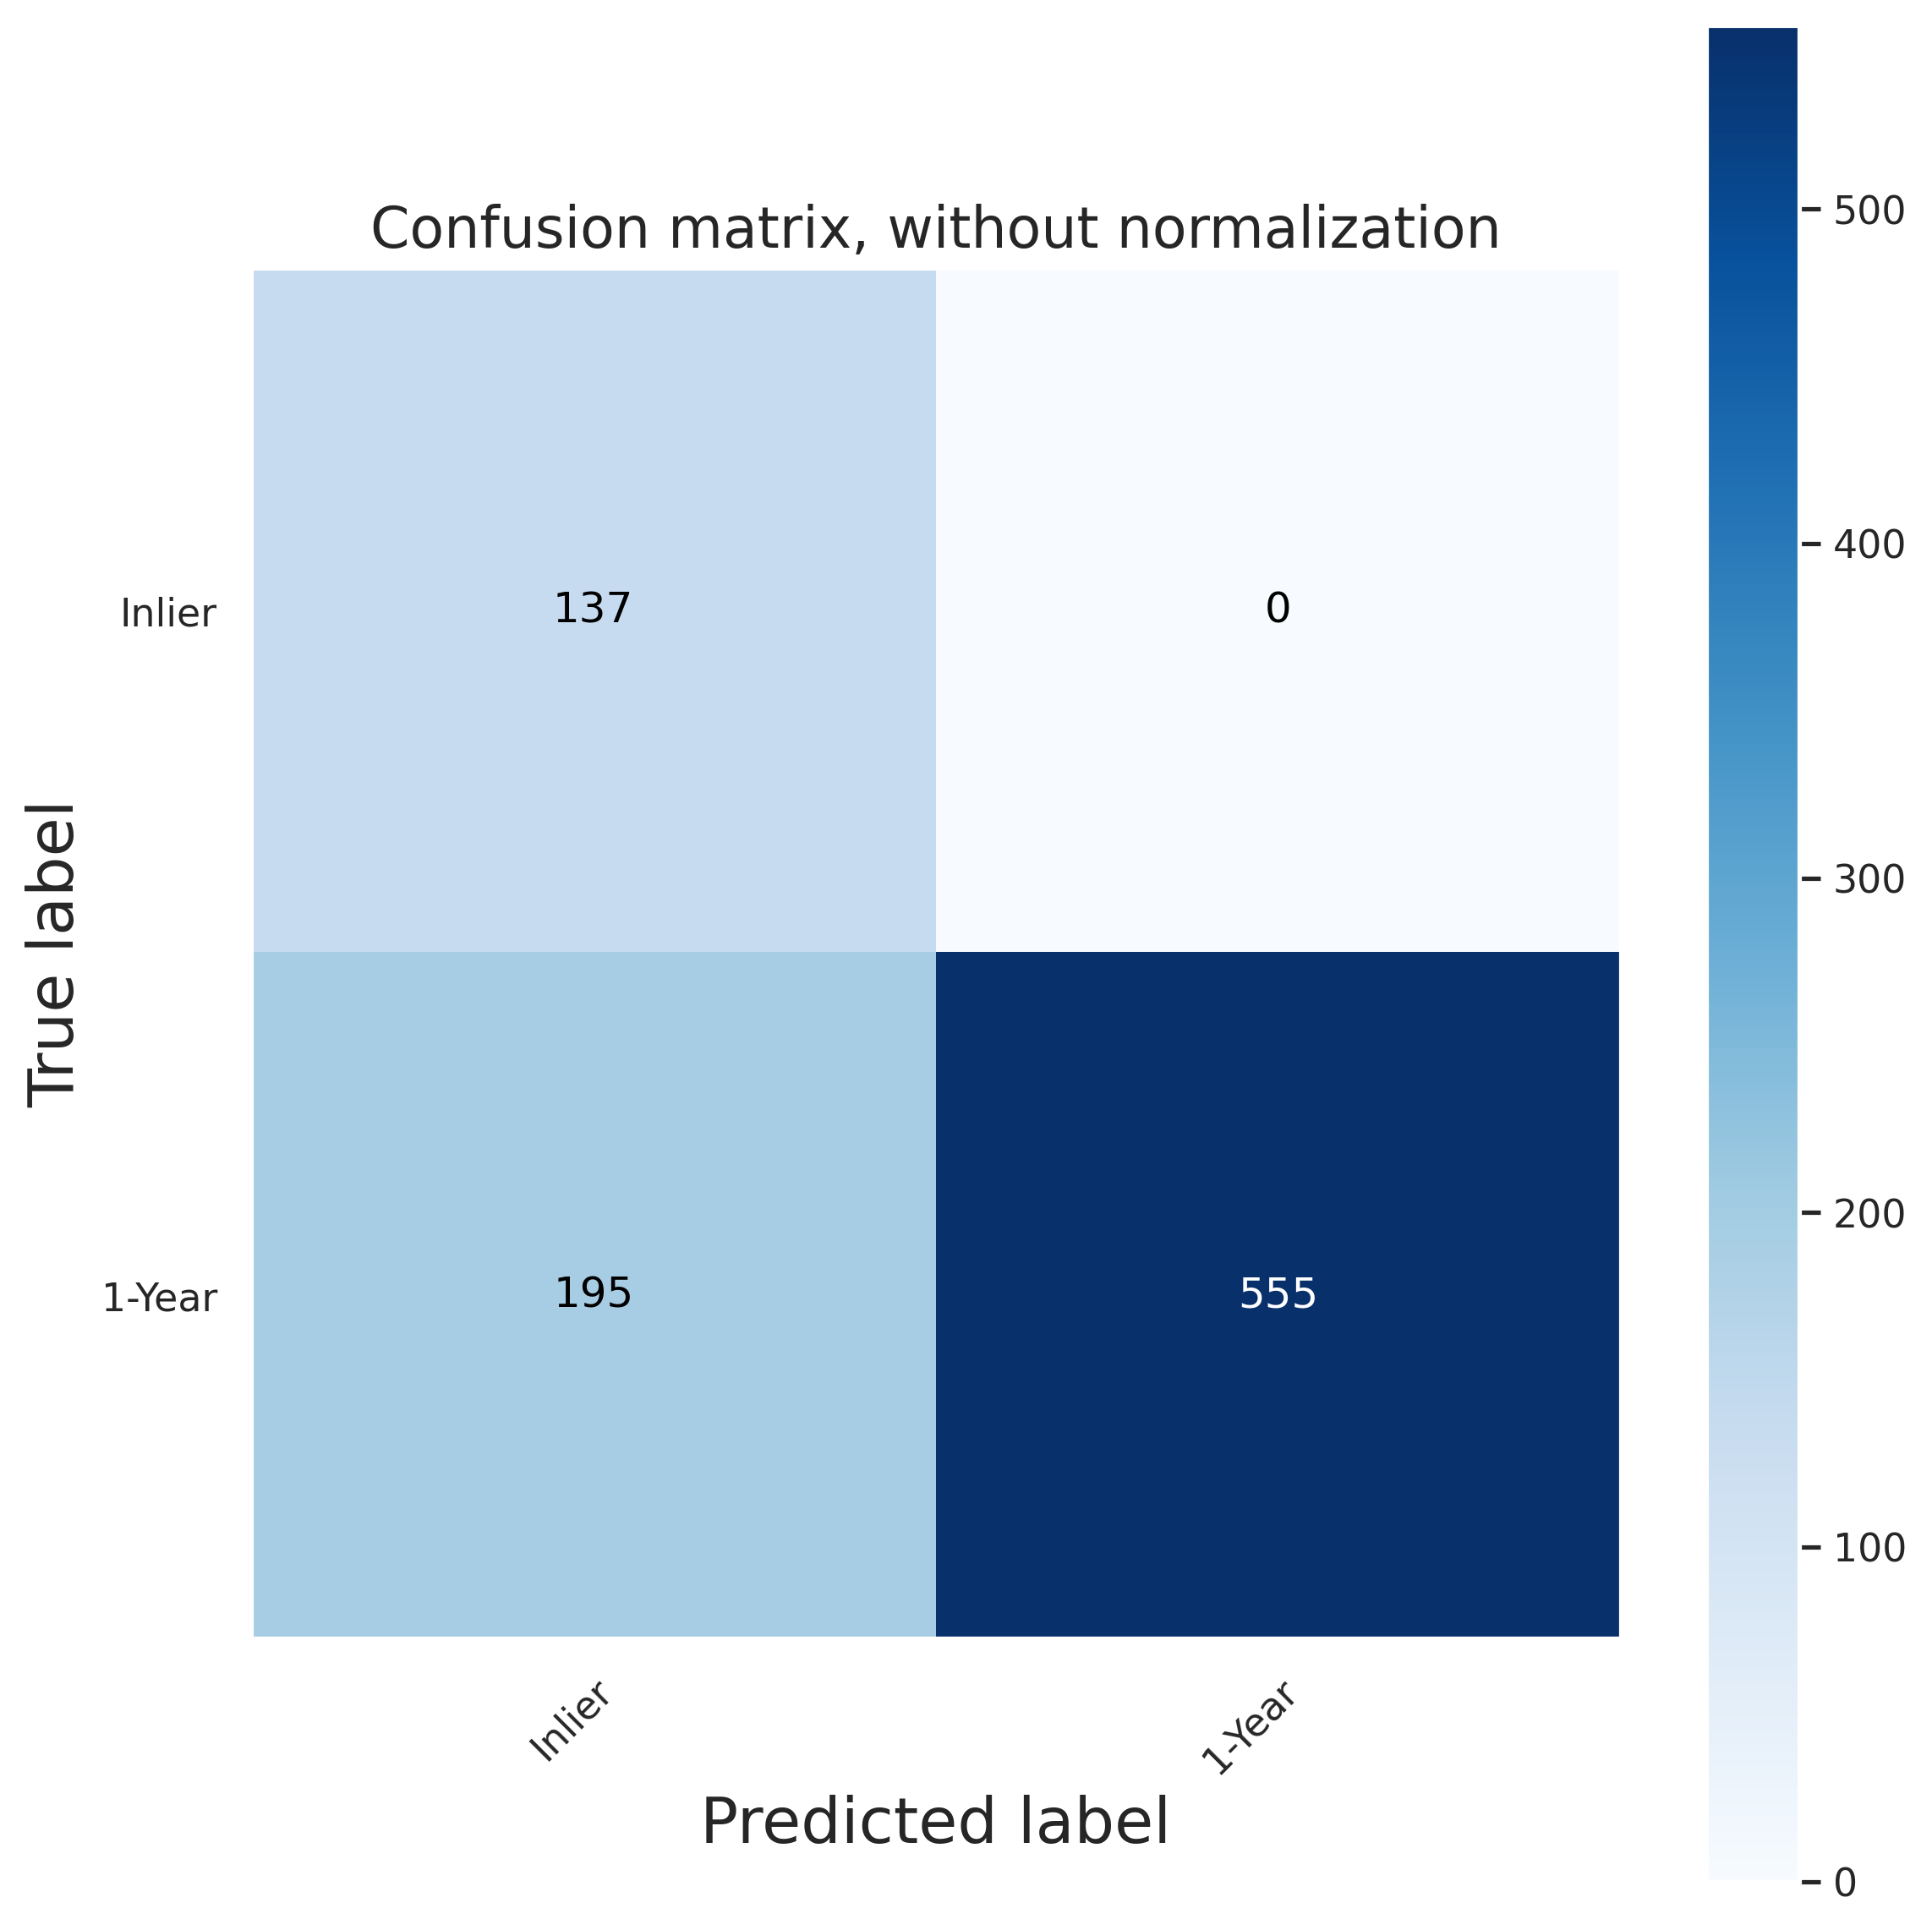

In [65]:
plot_confusion_matrix(y_true, y_pred, classes=["Inlier","1-Year"])
plt.grid(False)

## GMM

In [66]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [67]:
%%time
gmm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("GMM", GaussianMixture())
])

param_grid = dict(GMM__n_components = range(1,11),
                  GMM__covariance_type = ["full"])

grid = GridSearchCV(estimator=gmm_clf,
                    param_grid=param_grid,
                    cv=10, n_jobs=10,
                    verbose=1)

grid_result = grid.fit(train_data)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.5s


CPU times: user 1.72 s, sys: 2.5 s, total: 4.22 s
Wall time: 1.67 s


[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    1.4s finished


In [68]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("-----"*15)
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 1.378192 using {'GMM__covariance_type': 'full', 'GMM__n_components': 2}
---------------------------------------------------------------------------
0.535935 (1.135704) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 1}
1.378192 (1.005350) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 2}
1.246387 (1.119831) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 3}
1.291916 (1.178804) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 4}
1.282664 (1.299721) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 5}
1.066953 (1.401675) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 6}
0.875283 (1.573296) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 7}
0.644062 (1.908202) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 8}
0.744289 (1.481033) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 9}
0.680296 (1.396961) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 10}


In [83]:
best_params = grid.best_params_

best_gmm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("GMM", GaussianMixture())
]).set_params(**best_params)

best_gmm_clf.fit(X_train)

print("Training Likelihood: {:.3f}".format(best_gmm_clf.score(X_train)))
print("Testing Likelihood: {:.3f}".format(best_gmm_clf.score(X_test)))
print("1-year Likelihood: {:.3f}".format(best_gmm_clf.score(outlier_norms[0])))
print("2-year Likelihood: {:.3f}".format(best_gmm_clf.score(outlier_norms[1])))
print("8-year Likelihood: {:.3f}".format(best_gmm_clf.score(outlier_norms[-1])))

Training Likelihood: 2.000
Testing Likelihood: 1.919
1-year Likelihood: -51.564
2-year Likelihood: -41.496
8-year Likelihood: -10.098


In [84]:
train_score = -best_gmm_clf.score_samples(X_train)
test_score = -best_gmm_clf.score_samples(X_test)
outlier_scores = []
for data in outlier_norms:
    outlier_scores.append(-best_gmm_clf.score_samples(data))

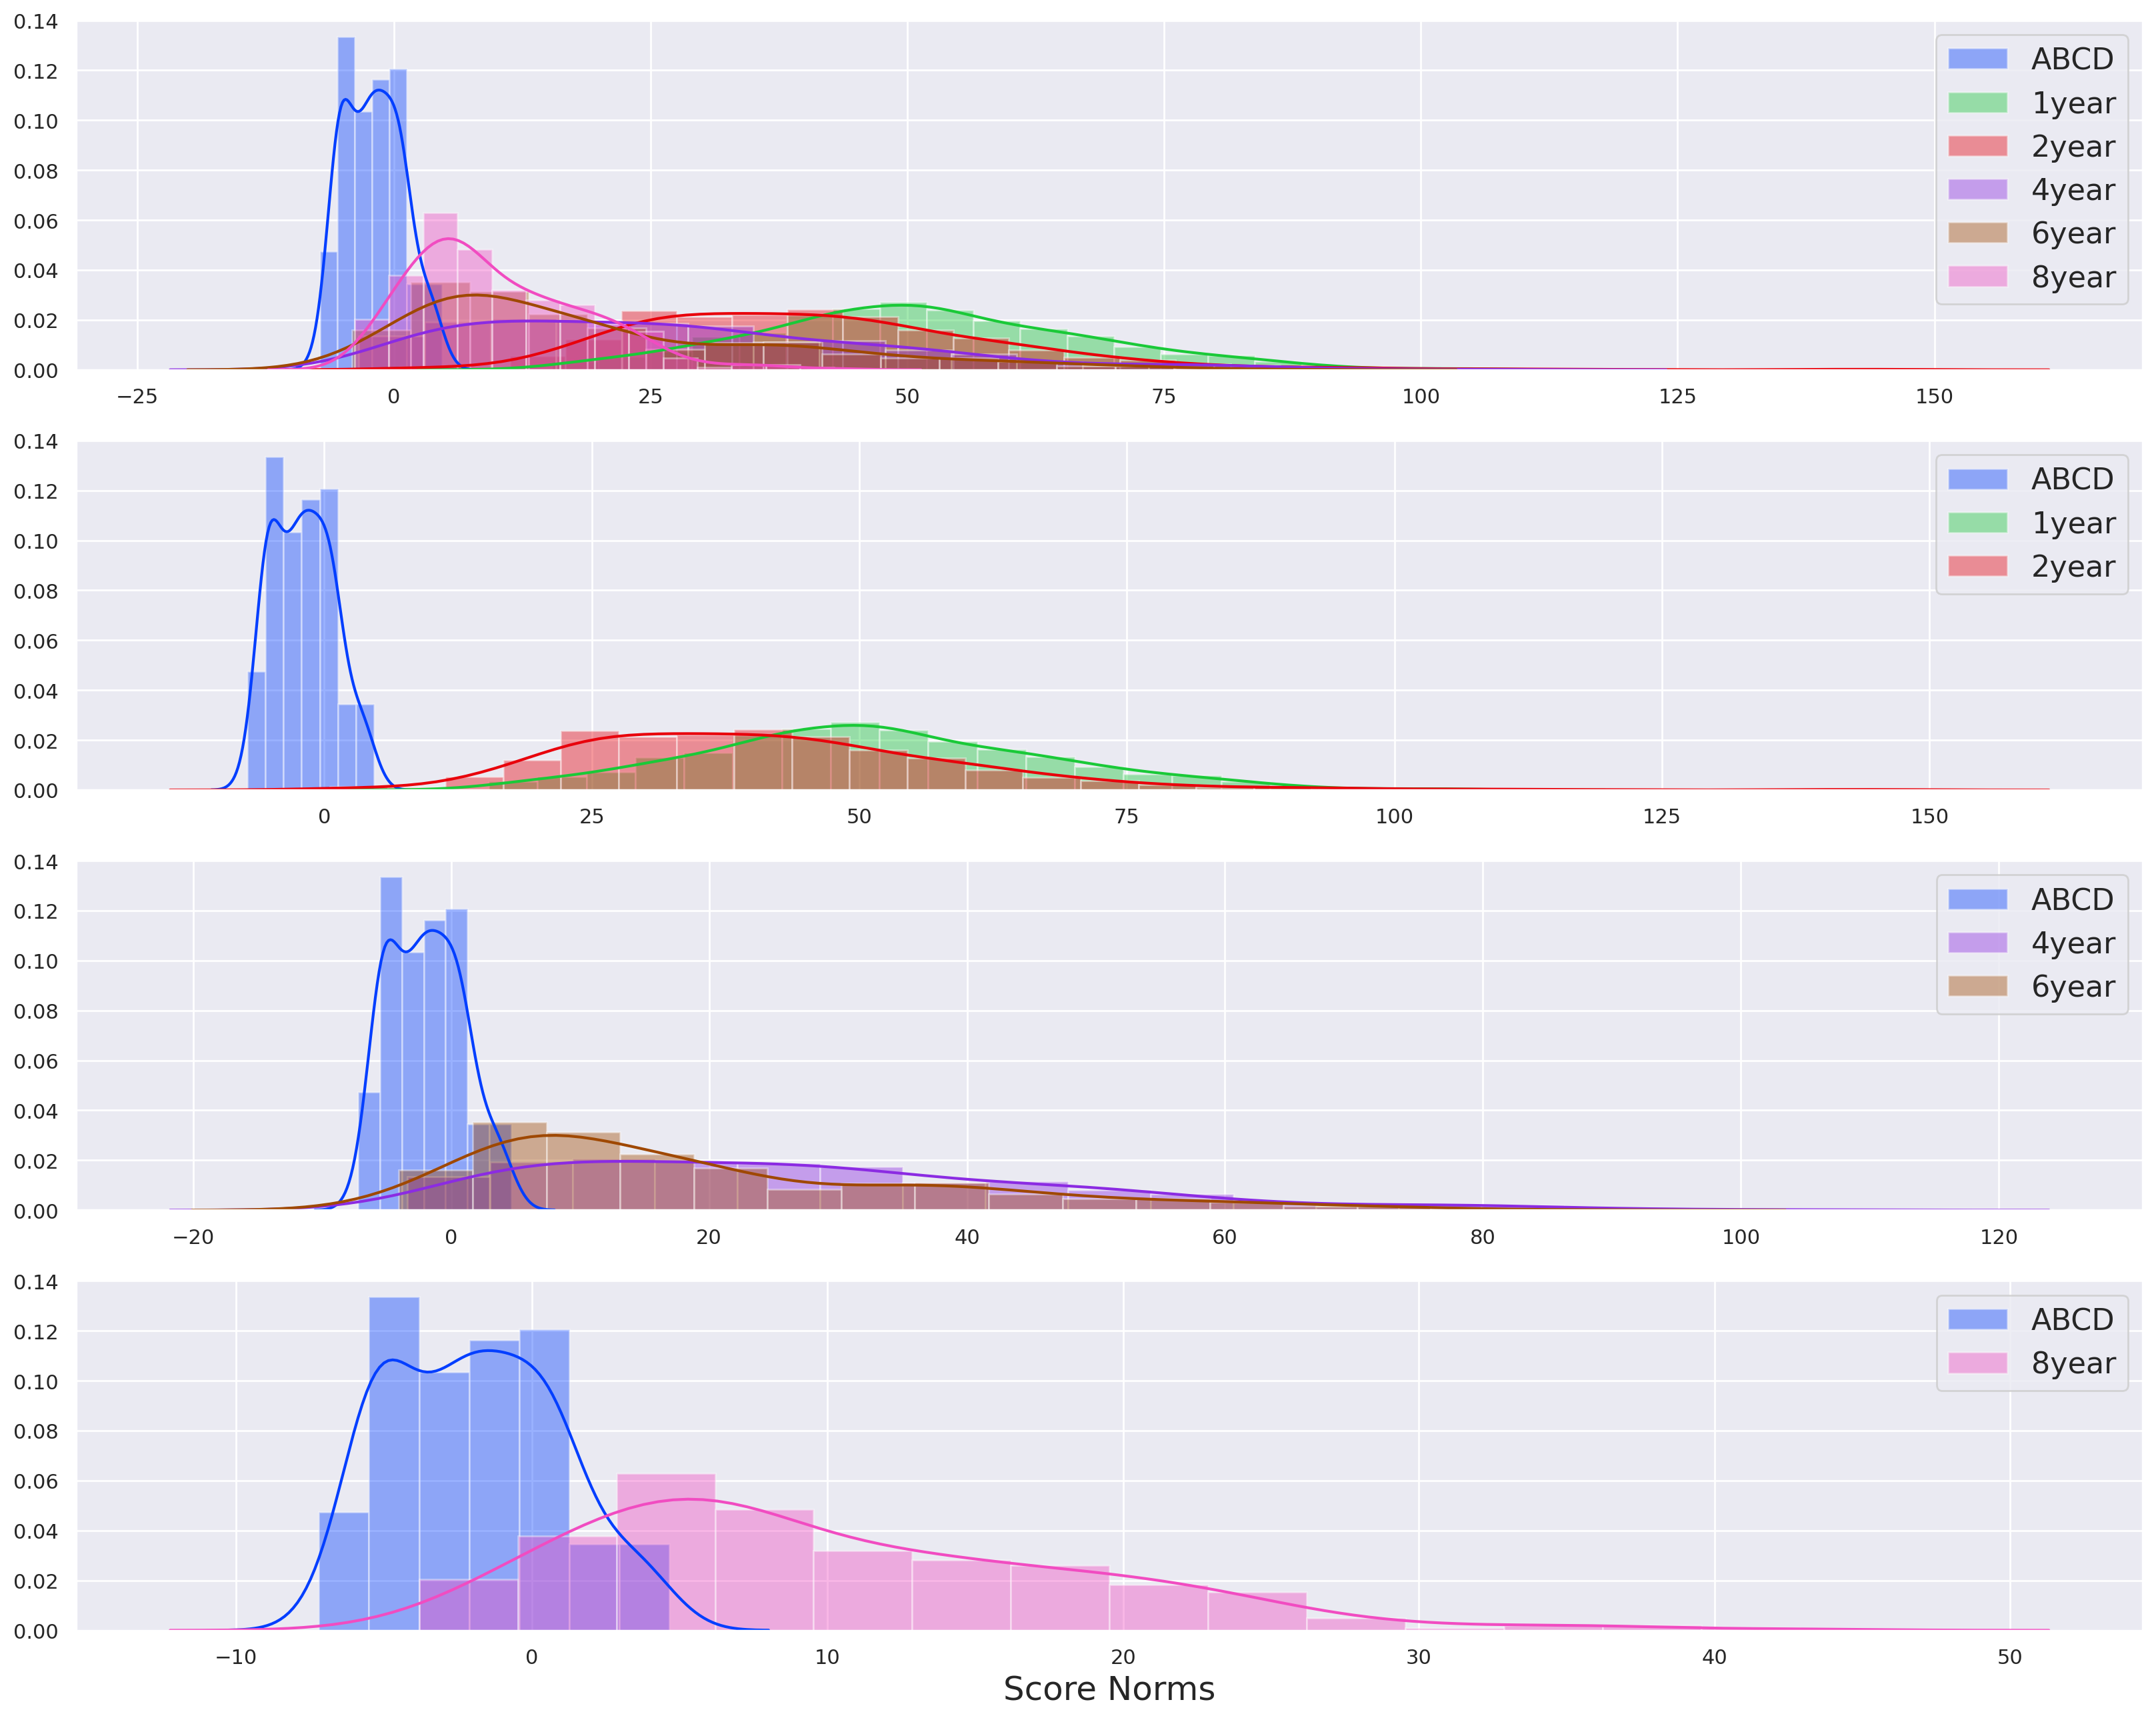

In [85]:
COLORS = sns.color_palette("bright")
# COLORS[0] = "blue" 
# COLORS[1] = "red" 

fig, axs = plt.subplots(4,1, figsize=(20,16))

# sns.distplot(train_score, color=COLORS[0], label=LABELS[0], ax=axs[0])
sns.distplot(test_score, color=COLORS[0], label=LABELS[1], ax=axs[0])
for idx, _score in enumerate(outlier_scores):
    idx += 2
    sns.distplot(_score, color=COLORS[idx], label=LABELS[idx], ax=axs[0])

start = 0
for col in range(1, axs.shape[0]):
    sns.distplot(test_score, color=COLORS[0], label=LABELS[1], ax=axs[col])
    
    for idx, _score in enumerate(outlier_scores[start:start+2]):
        idx += 2*col
        sns.distplot(_score, color=COLORS[idx], label=LABELS[idx], ax=axs[col])    
    
    start += 2

for ax in axs: ax.legend(fontsize=16)
axs[-1].set(xlabel="Score Norms")
plt.show()

# Could do PCA of covariance matrix of each component - best_gmm_clf[].covariances_
# Look at different eigen vectors / values of each component 

**ABCD vs 1-year**

In [76]:
metrics(test_score, outlier_scores[0], plot=False, verbose=True)
plt.show()

Inlier vs Outlier
----------------
ROC-AUC: 1.0000
PR-AUC: 1.0000
Avg Prec: 1.0000


**ABCD vs 8-year**

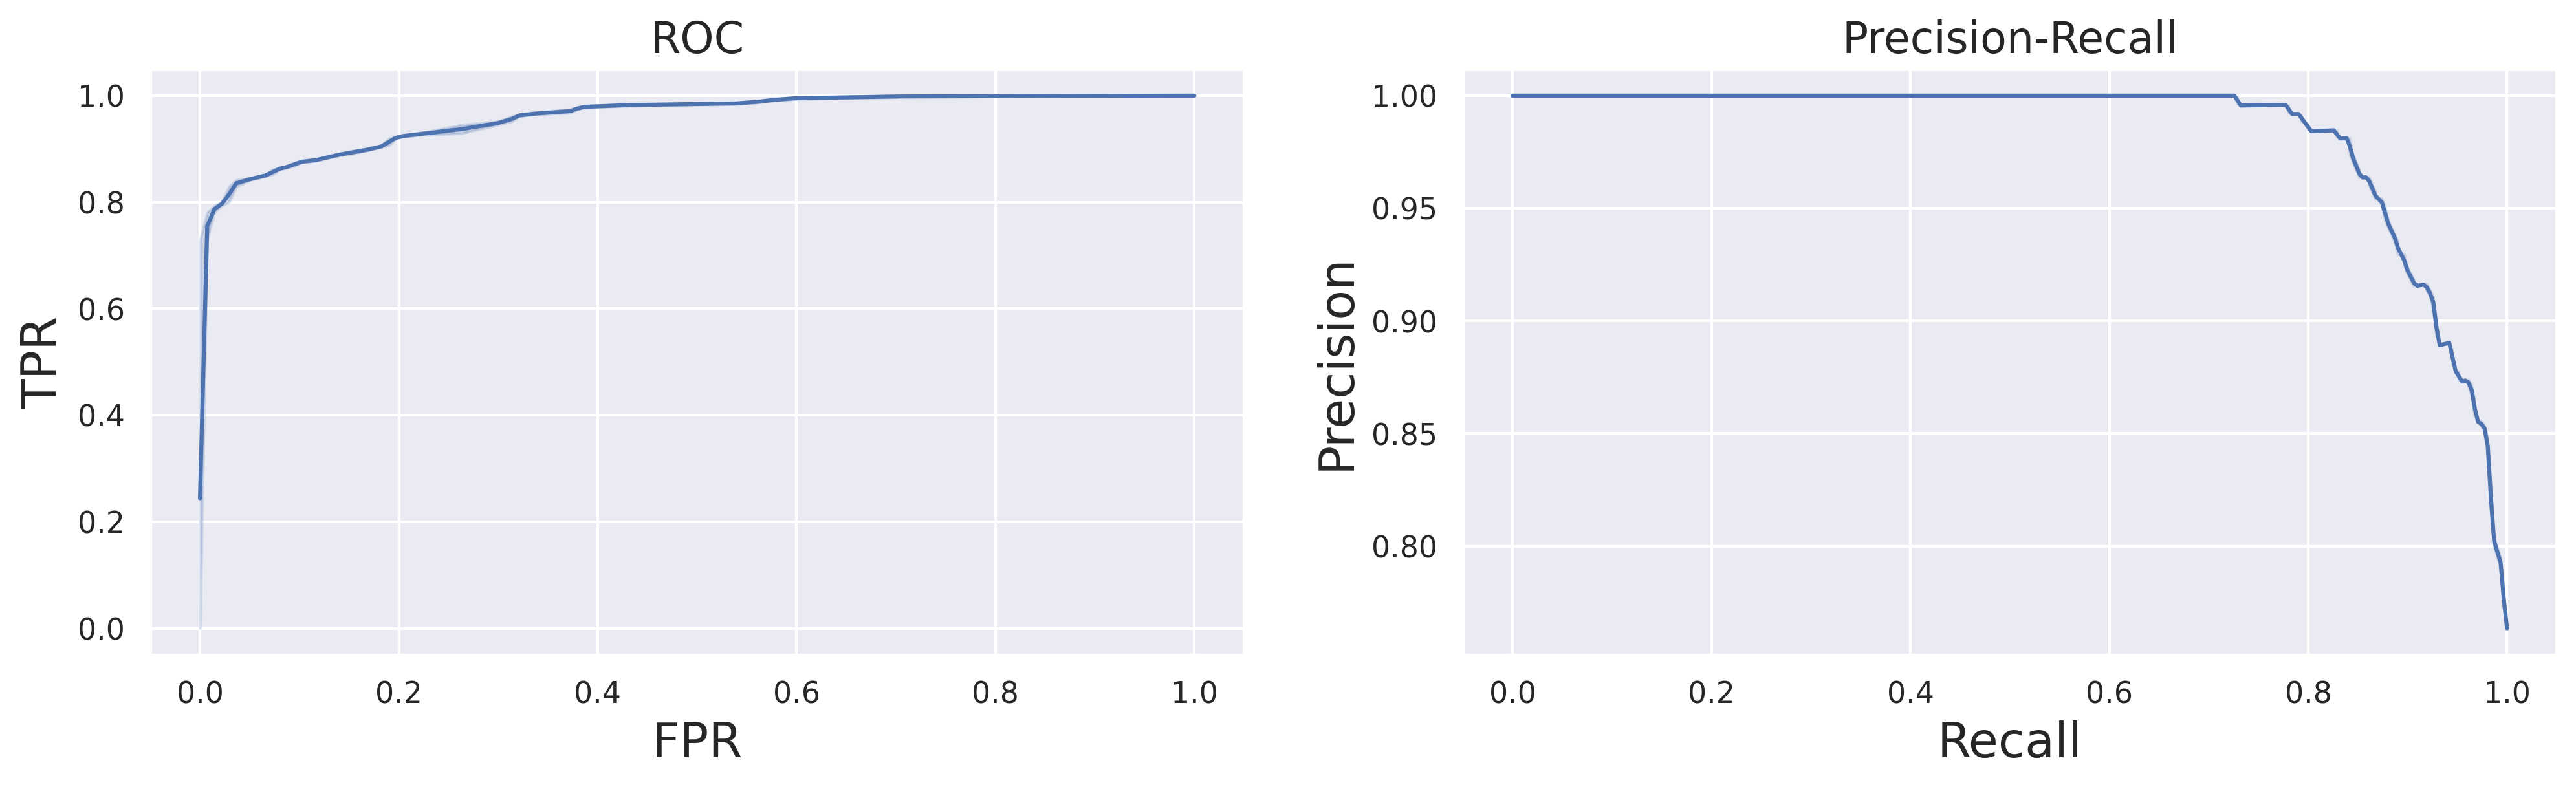

Inlier vs Outlier
----------------
ROC-AUC: 0.9592
PR-AUC: 0.9832
Avg Prec: 0.9832


In [77]:
metrics(test_score, outlier_scores[-1], plot=True, verbose=True)
plt.show()

0: -1.396619 using {'GMM__covariance_type': 'full', 'GMM__n_components': 3}
1: -1.408089 using {'GMM__covariance_type': 'full', 'GMM__n_components': 3}
2: -1.408224 using {'GMM__covariance_type': 'full', 'GMM__n_components': 2}
3: -1.427869 using {'GMM__covariance_type': 'full', 'GMM__n_components': 1}
4: -1.425295 using {'GMM__covariance_type': 'full', 'GMM__n_components': 2}
5: -1.425599 using {'GMM__covariance_type': 'full', 'GMM__n_components': 1}
6: -1.410499 using {'GMM__covariance_type': 'full', 'GMM__n_components': 3}
7: -1.414203 using {'GMM__covariance_type': 'full', 'GMM__n_components': 3}
8: -1.419581 using {'GMM__covariance_type': 'full', 'GMM__n_components': 9}
9: -1.417217 using {'GMM__covariance_type': 'full', 'GMM__n_components': 3}


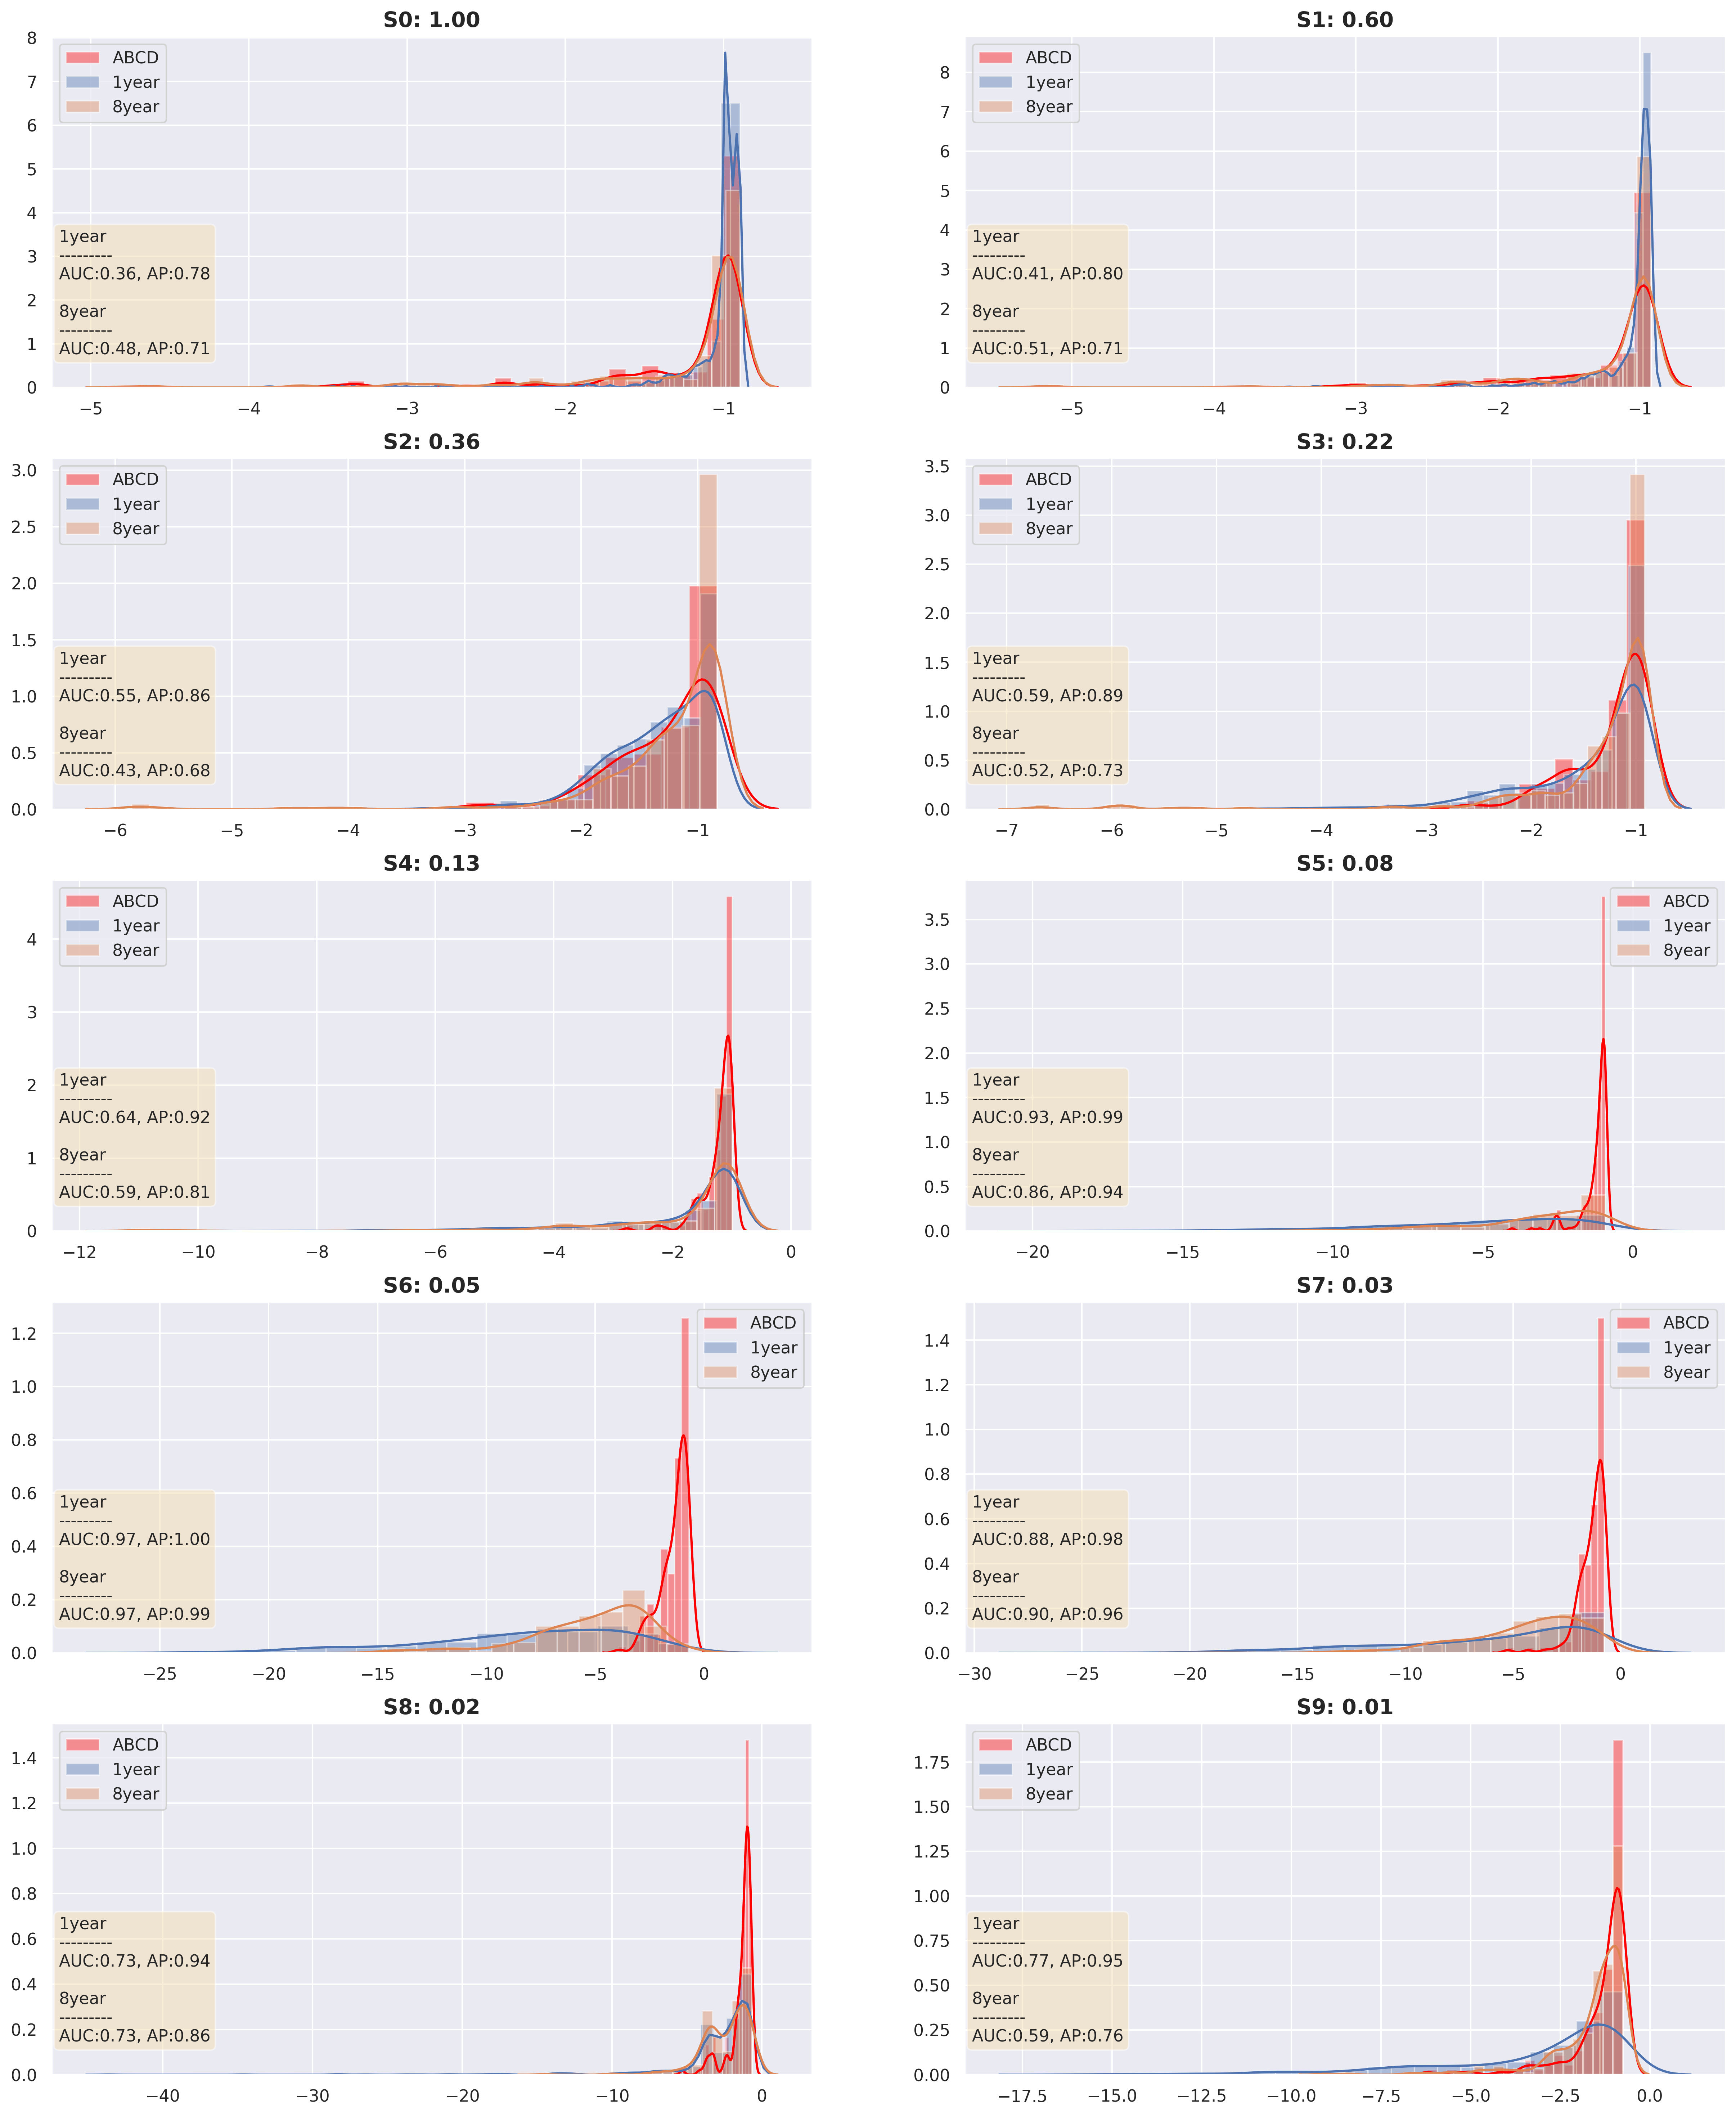

In [80]:
# progress_bar = tqdm(sigmas, desc='Sigma: ?')
fig, axs = plt.subplots(5,2, figsize=(20,25))
axs = axs.flatten()

for idx, sigma in enumerate(SIGMAS):
    _x_train = train_data[:, idx:idx+1]
    _x_test = test_data[:, idx:idx+1]
    _yr1 = outlier_norms[0][:, idx:idx+1]
    _yr2 = outlier_norms[-1][:, idx:idx+1]
    
    gmm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("GMM", GaussianMixture())
    ])
    
    
    # Each sigma gets its own hyperparameter-tuned model
    param_grid = dict(GMM__n_components = range(1,11),
                      GMM__covariance_type = ["full"])

    grid = GridSearchCV(estimator=gmm_clf,
                        param_grid=param_grid,
                        cv=10, n_jobs=10)
    grid_result = grid.fit(_x_train)
    print("%d: %f using %s" % (idx, grid_result.best_score_, grid_result.best_params_))
    
    
    best_gmm_clf = gmm_clf.set_params(**grid.best_params_)
    best_gmm_clf.fit(_x_train)
    
    _train_score = best_gmm_clf.score_samples(_x_train)
    _inlier_score = best_gmm_clf.score_samples(_x_test)
    yr1_score = best_gmm_clf.score_samples(_yr1)
    yr2_score = best_gmm_clf.score_samples(_yr2)

#     sns.distplot(_train_score, label="Training", ax=axs[idx])
    sns.distplot(_inlier_score, color="red", label=LABELS[1], ax=axs[idx])
    sns.distplot(yr1_score, label=LABELS[2], ax=axs[idx])
    sns.distplot(yr2_score, label=LABELS[-1], ax=axs[idx])

    textstr = '\n'.join((
        LABELS[2],
        "---------",
        'AUC:%.2f, AP:%.2f' % (metrics(-_inlier_score, -yr1_score)[:-1]),
        '',
        LABELS[-1],
        "---------",
        'AUC:%.2f, AP:%.2f' % (metrics(-_inlier_score, -yr2_score)[:-1])))

    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    # place a text box in upper left in axes coords
    axs[idx].text(0.01, 0.45, textstr, transform=axs[idx].transAxes, fontsize=11,
            verticalalignment='top', bbox=props)
    
    axs[idx].set_title("S{:d}: {:.2f}".format(idx, sigma), fontsize=14, fontweight="bold")  
    
    axs[idx].legend()

plt.show()

> **S6 shows the best separation**